# Setup

In [94]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png"))
options(jupyter.plot_scale = 1.5)
options(warn = -1)
require("pacman")
pacman::p_load(tidyverse, ggplot2, latex2exp, fpp2, 
               ggfortify, ggpubr, zoo, lubridate, mgcv,
               aod, tseries)

source('../Scripts/ReadData.R')
source('../Scripts/ModelSelection.R')
source('../Scripts/ResidualAnalysis.R')
source('../Scripts/Forecasting.R')

# Trend-Seasonal Splines Model

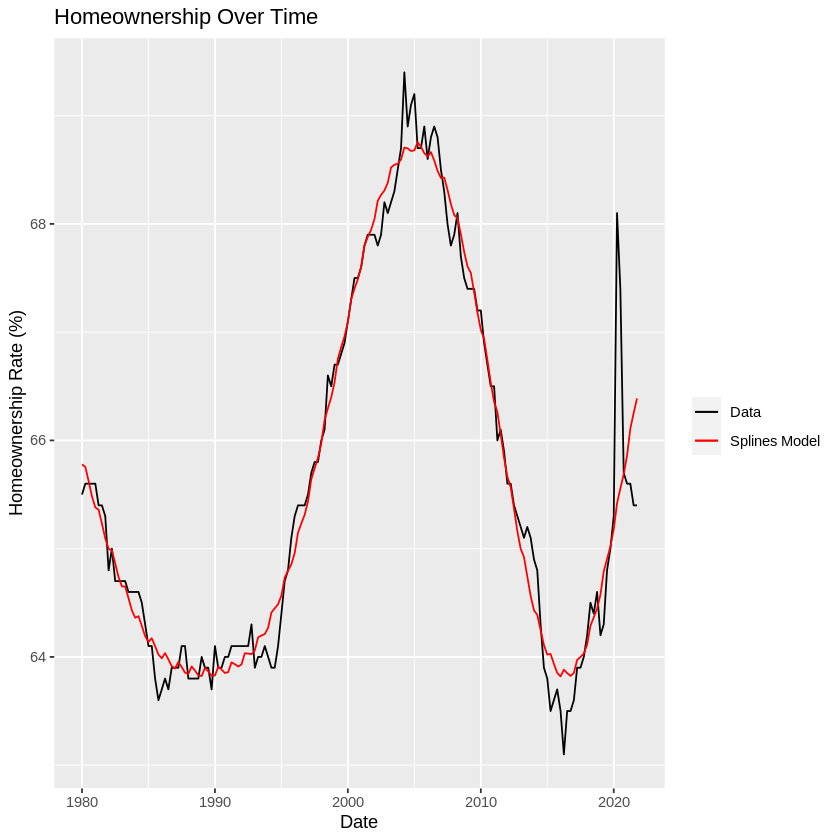


	Augmented Dickey-Fuller Test

data:  ho_splines$residuals
Dickey-Fuller = -5.4184, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


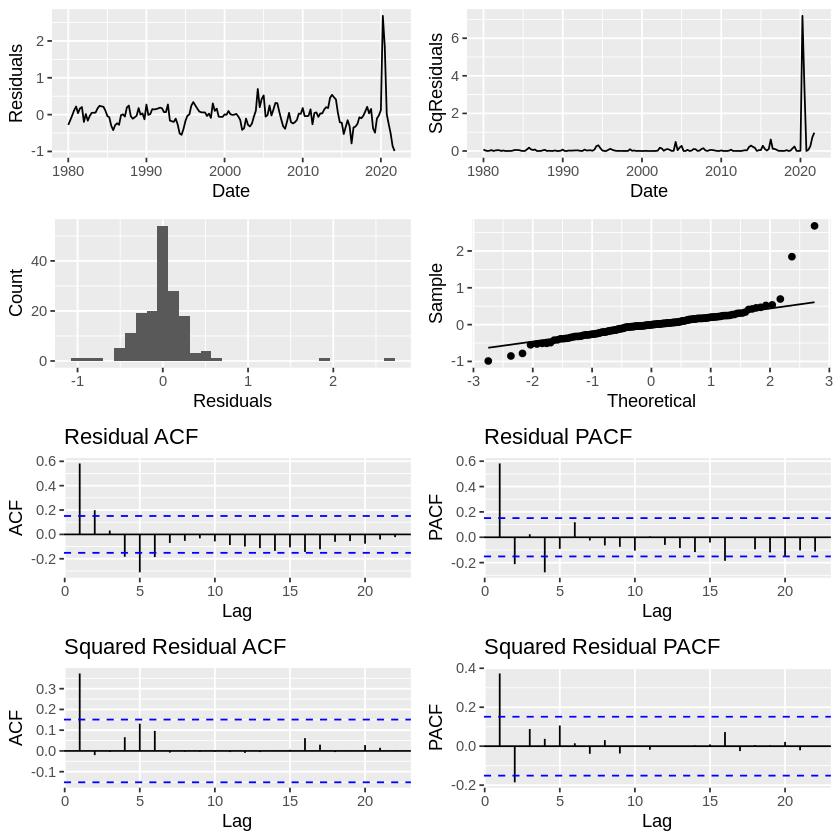

In [98]:
homeownership <- read_homeownership()
ho_splines <- gam(Value ~ s(as.numeric(Date)) + Quarter - 1 , data = homeownership)

homeownership%>% ggplot() + 
    geom_line(aes(x = Date, y = Value, color = "Data")) + 
    geom_line(aes(x = Date, y = fitted(ho_splines), color = "Splines Model"))+
    labs(x = "Date", y = "Homeownership Rate (%)", title = "Homeownership Over Time") +
    scale_color_manual("", values = c("Data" = "black", "Splines Model" = "red"))

residual_analysis(ho_splines, homeownership$Date)
adf.test(ho_splines$residuals)

In [43]:
ho_splines_redux <- gam(Value ~ s(as.numeric(Date)), data = homeownership)
anova.gam(ho_splines_redux, ho_splines, test = "Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,158.0414,21.08469,NA,NA,NA
2,155.0422,20.91759,2.999233,0.1670988,0.7429988


No need for seasonality component. Doesn't add anything to model

## Outlier Examination

In [3]:
homeownership[tsoutliers(homeownership$Value)$index,]

,Date,Quarter,Value
,<date>,<fct>,<dbl>
162,2020-04-01,Q2,68.1
163,2020-07-01,Q3,67.4


### Box-Cox Transformation

In [4]:
BoxCox.lambda(homeownership$Value)

[1] -0.9999242

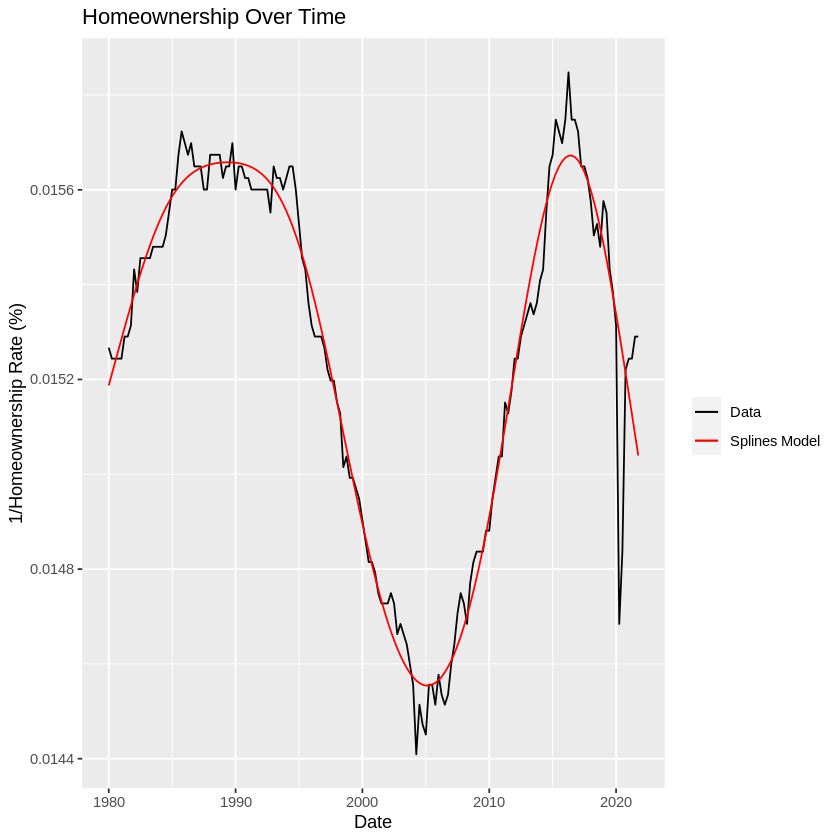


	Augmented Dickey-Fuller Test

data:  bc_homeownership_splines$residuals
Dickey-Fuller = -5.4524, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


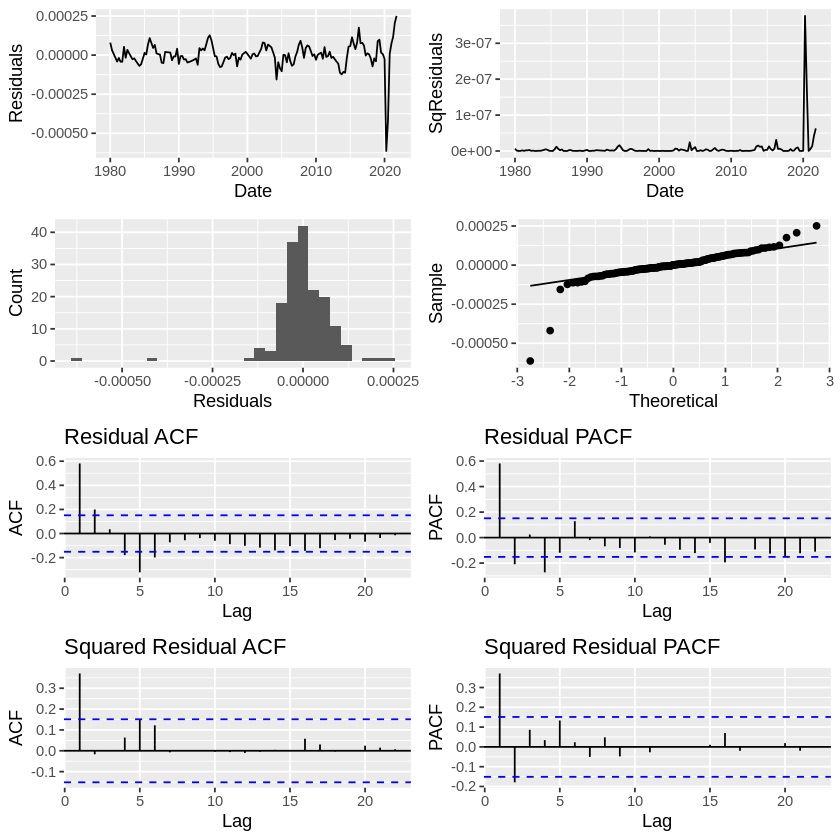

In [99]:
bc_homeownership <- homeownership %>% mutate(Value = 1/Value)
bc_homeownership_splines <- gam(Value ~ s(as.numeric(Date)), data = bc_homeownership)

bc_homeownership%>% ggplot() + 
    geom_line(aes(x = Date, y = Value, color = "Data")) + 
    geom_line(aes(x = Date, y = fitted(bc_homeownership_splines), color = "Splines Model"))+
    labs(x = "Date", y = "1/Homeownership Rate (%)", title = "Homeownership Over Time") +
    scale_color_manual("", values = c("Data" = "black", "Splines Model" = "red"))

residual_analysis(bc_homeownership_splines, bc_homeownership$Date)
adf.test(bc_homeownership_splines$residuals)

### Log Transformation

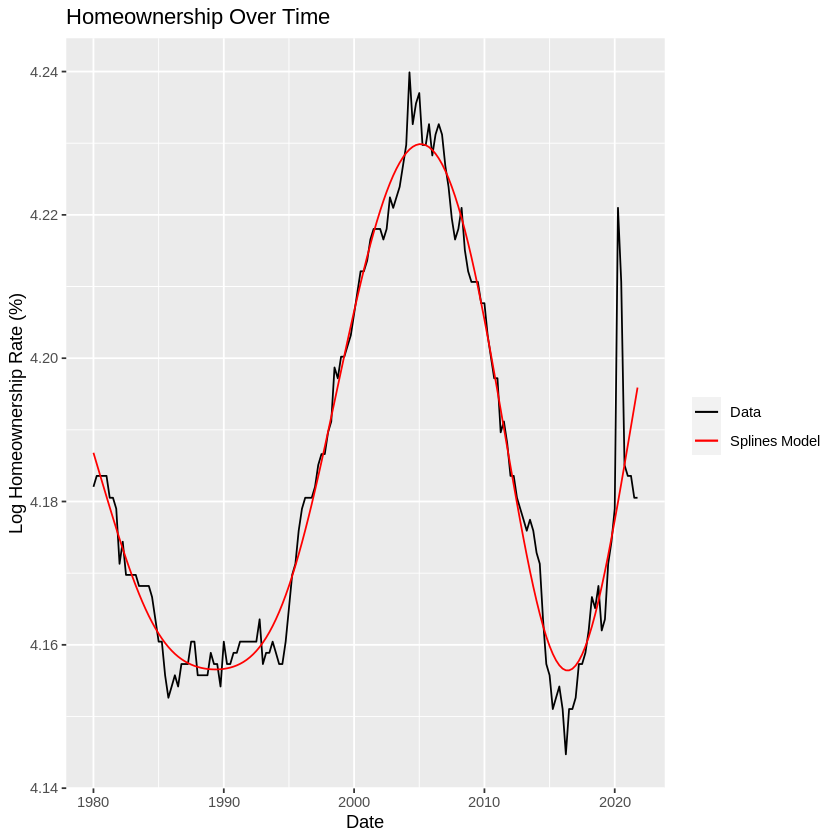


	Augmented Dickey-Fuller Test

data:  log_homeownership_splines$residuals
Dickey-Fuller = -5.3793, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


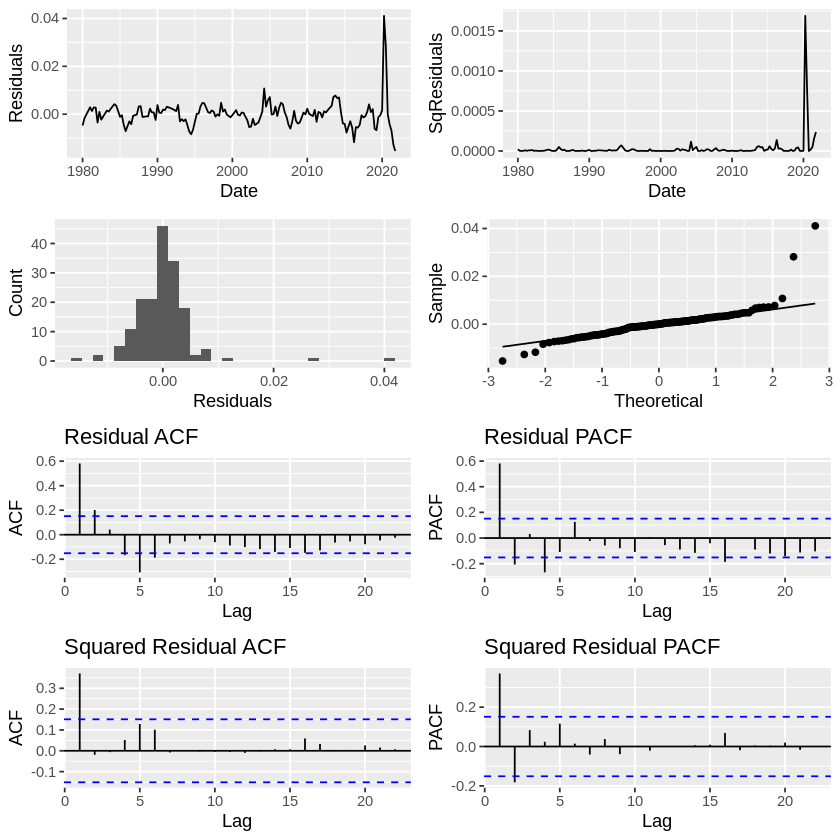

In [100]:
log_homeownership <- homeownership %>% mutate(Value = log(Value))
log_homeownership_splines <- gam(Value ~ s(as.numeric(Date)), data = log_homeownership)

log_homeownership%>% ggplot() + 
    geom_line(aes(x = Date, y = Value, color = "Data")) + 
    geom_line(aes(x = Date, y = fitted(log_homeownership_splines), color = "Splines Model"))+
    labs(x = "Date", y = "Log Homeownership Rate (%)", title = "Homeownership Over Time") +
    scale_color_manual("", values = c("Data" = "black", "Splines Model" = "red"))

residual_analysis(log_homeownership_splines, log_homeownership$Date)
adf.test(log_homeownership_splines$residuals)

### Outlier Removal via Interpolation

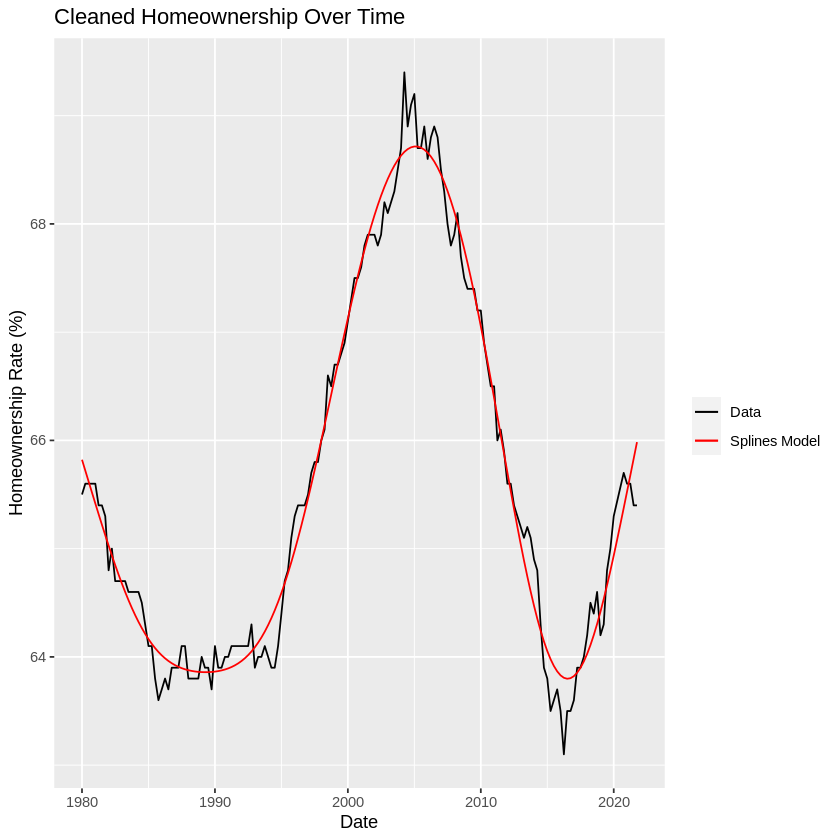


	Augmented Dickey-Fuller Test

data:  clean_homeownership_splines$residuals
Dickey-Fuller = -4.8219, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


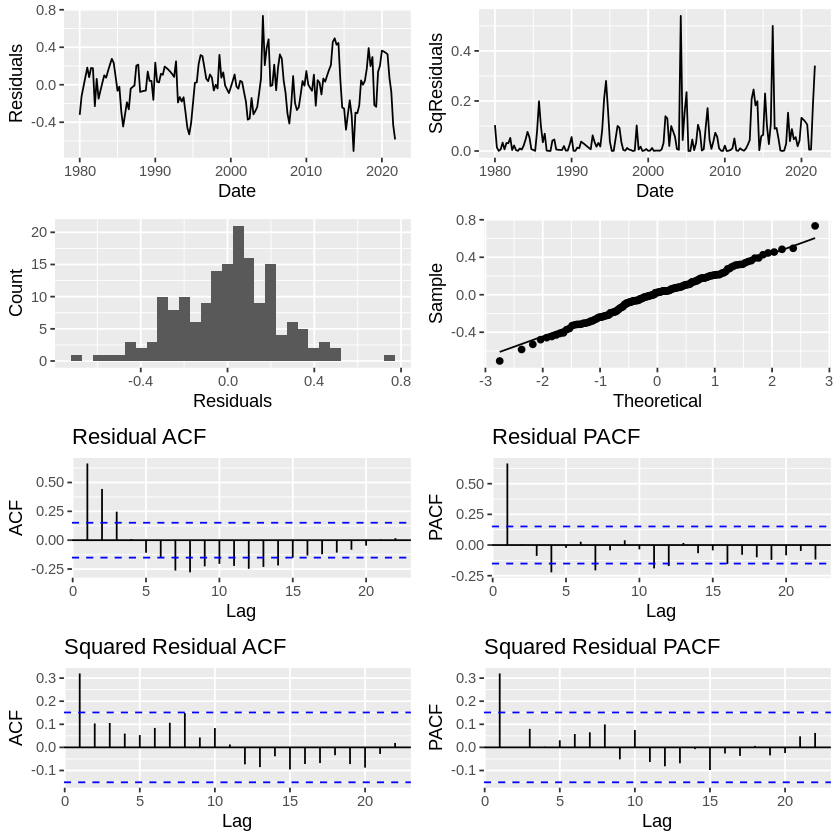

In [102]:
clean_homeownership <- homeownership %>% mutate(Value = tsclean(Value))
clean_homeownership_splines <- gam(Value ~ s(as.numeric(Date)), data = clean_homeownership)

clean_homeownership%>% ggplot() + 
    geom_line(aes(x = Date, y = Value, color = "Data")) + 
    geom_line(aes(x = Date, y = fitted(clean_homeownership_splines), color = "Splines Model"))+
    labs(x = "Date", y = "Homeownership Rate (%)", title = "Cleaned Homeownership Over Time") +
    scale_color_manual("", values = c("Data" = "black", "Splines Model" = "red"))

residual_analysis(clean_homeownership_splines, clean_homeownership$Date)
adf.test(clean_homeownership_splines$residuals)

# Differenced Data


	Augmented Dickey-Fuller Test

data:  diff_homeownership$Value
Dickey-Fuller = -4.0197, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


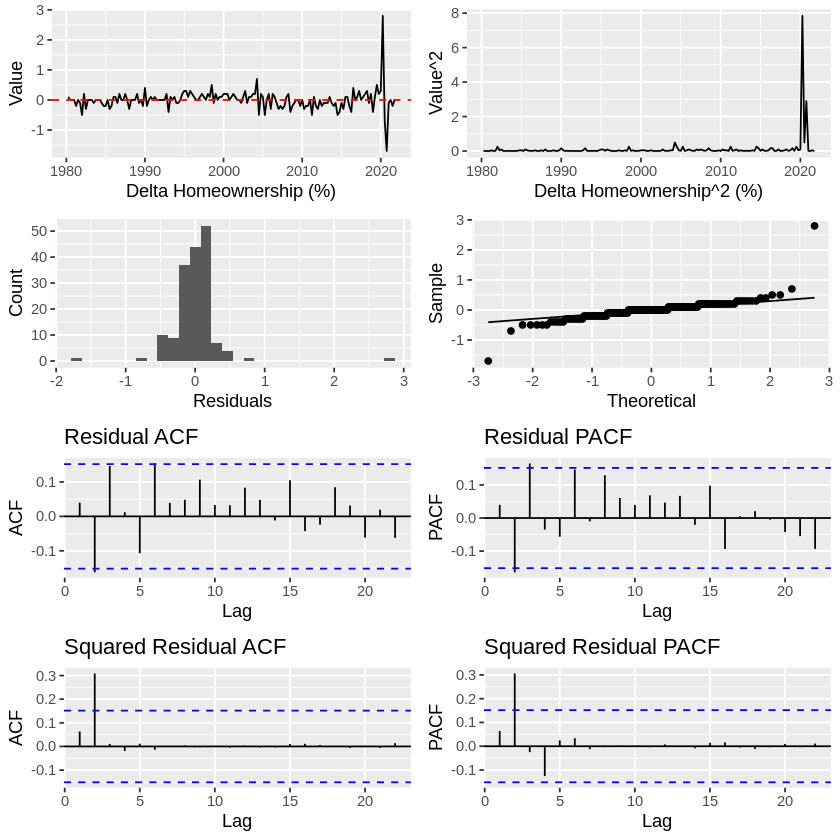

In [106]:
diff_homeownership <- homeownership %>% mutate(Value = c(NA, diff(Value))) %>% drop_na
diff_plot <- diff_homeownership %>% ggplot() +
    geom_line(aes(x = Date, y = Value)) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(x = "Delta Homeownership (%)")
sqdiff_plot <- diff_homeownership %>% ggplot() +
    geom_line(aes(x = Date, y = Value^2)) +
    labs(x = "Delta Homeownership^2 (%)")
diff_acf <- ggAcf(diff_homeownership$Value) + labs(title = "Residual ACF")
diff_pacf <- ggAcf(diff_homeownership$Value, type = "partial") + labs(title = "Residual PACF")
sqdiff_acf <- ggAcf(diff_homeownership$Value^2) + labs(title = "Squared Residual ACF")
sqdiff_pacf <- ggAcf(diff_homeownership$Value ^ 2, type = "partial") + labs(title = "Squared Residual PACF")
diff_hist <- diff_homeownership %>% ggplot() +
    geom_histogram(aes(x = Value), bins = 30) +
    labs(x = "Residuals", y = "Count")
diff_qq <- diff_homeownership %>% ggplot(aes(sample = Value)) + 
    stat_qq() + stat_qq_line() +
    labs(x = "Theoretical", y = "Sample")

ggarrange(diff_plot, sqdiff_plot, diff_hist, diff_qq,
        diff_acf, diff_pacf, sqdiff_acf, sqdiff_pacf,
        nrow = 4, ncol = 2)

adf.test(diff_homeownership$Value)

## Outlier Examination

In [112]:
diff_homeownership[tsoutliers(diff_homeownership$Value)$index,]

,Date,Quarter,Value
,<date>,<fct>,<dbl>
161,2020-04-01,Q2,2.8
163,2020-10-01,Q4,-1.7


### Log-Difference Transformation


	Augmented Dickey-Fuller Test

data:  log_diff_ho$Value
Dickey-Fuller = -4.0155, Lag order = 5, p-value = 0.01012
alternative hypothesis: stationary


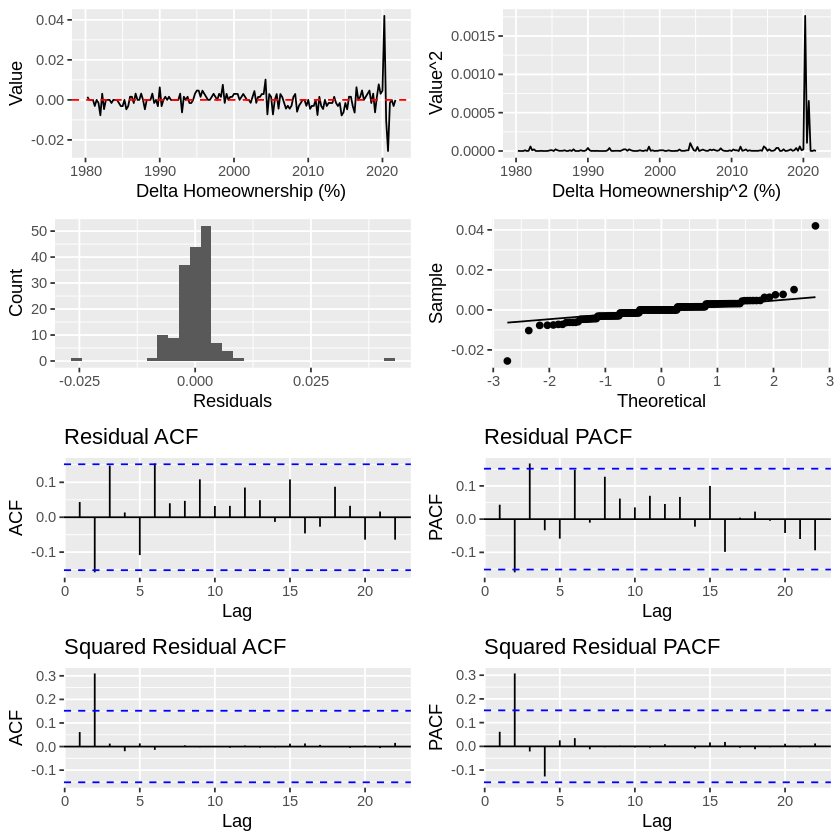

In [108]:
log_diff_ho <- homeownership %>% mutate(Value = c(NA, diff(log(Value)))) %>% drop_na
diff_plot <- log_diff_ho %>% ggplot() +
    geom_line(aes(x = Date, y = Value)) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(x = "Delta Homeownership (%)")
sqdiff_plot <- log_diff_ho %>% ggplot() +
    geom_line(aes(x = Date, y = Value^2)) +
    labs(x = "Delta Homeownership^2 (%)")
diff_acf <- ggAcf(log_diff_ho$Value) + labs(title = "Residual ACF")
diff_pacf <- ggAcf(log_diff_ho$Value, type = "partial") + labs(title = "Residual PACF")
sqdiff_acf <- ggAcf(log_diff_ho$Value^2) + labs(title = "Squared Residual ACF")
sqdiff_pacf <- ggAcf(log_diff_ho$Value ^ 2, type = "partial") + labs(title = "Squared Residual PACF")
diff_hist <- log_diff_ho %>% ggplot() +
    geom_histogram(aes(x = Value), bins = 30) +
    labs(x = "Residuals", y = "Count")
diff_qq <- log_diff_ho %>% ggplot(aes(sample = Value)) + 
    stat_qq() + stat_qq_line() +
    labs(x = "Theoretical", y = "Sample")

ggarrange(diff_plot, sqdiff_plot, diff_hist, diff_qq,
        diff_acf, diff_pacf, sqdiff_acf, sqdiff_pacf,
        nrow = 4, ncol = 2)

adf.test(log_diff_ho$Value)

### Outlier Removal via Interpolation


	Augmented Dickey-Fuller Test

data:  clean_diff_ho$Value
Dickey-Fuller = -2.9575, Lag order = 5, p-value = 0.1767
alternative hypothesis: stationary


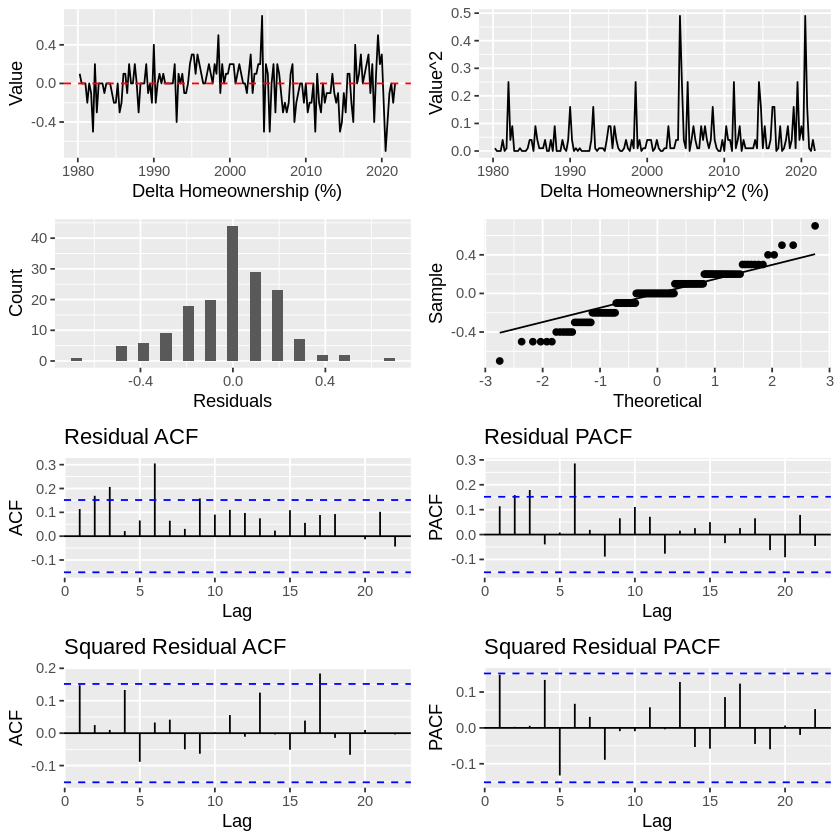

In [118]:
clean_diff_ho <- diff_homeownership %>% mutate(Value = tsclean(Value))
diff_plot <- clean_diff_ho %>% ggplot() +
    geom_line(aes(x = Date, y = Value)) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    labs(x = "Delta Homeownership (%)")
sqdiff_plot <- clean_diff_ho %>% ggplot() +
    geom_line(aes(x = Date, y = Value^2)) +
    labs(x = "Delta Homeownership^2 (%)")
diff_acf <- ggAcf(clean_diff_ho$Value) + labs(title = "Residual ACF")
diff_pacf <- ggAcf(clean_diff_ho$Value, type = "partial") + labs(title = "Residual PACF")
sqdiff_acf <- ggAcf(clean_diff_ho$Value^2) + labs(title = "Squared Residual ACF")
sqdiff_pacf <- ggAcf(clean_diff_ho$Value ^ 2, type = "partial") + labs(title = "Squared Residual PACF")
diff_hist <- clean_diff_ho %>% ggplot() +
    geom_histogram(aes(x = Value), bins = 30) +
    labs(x = "Residuals", y = "Count")
diff_qq <- clean_diff_ho %>% ggplot(aes(sample = Value)) + 
    stat_qq() + stat_qq_line() +
    labs(x = "Theoretical", y = "Sample")

ggarrange(diff_plot, sqdiff_plot, diff_hist, diff_qq,
        diff_acf, diff_pacf, sqdiff_acf, sqdiff_pacf,
        nrow = 4, ncol = 2)

adf.test(clean_diff_ho$Value)